# Multi Image Classification using Tensorflow

Name : `Kamil Riyadi Alam Situmeang`

Batch : `FTDS009`

## I. Introduction

This notebook is part of `NUTRIEND` project developed by `Anita Antono, Kamil Riyadi, Kevin Boy Gunawan, & Luthfi Fadhillah` as final project for `Hacktiv8 Fulltime Data Science Program`

### I.1 Project Background
In this project, I will try to implement `Convolutional Neural Network` in image classification task using `Tensorflow` library.\
I will try to utilize `Pre-trained model` and `Transfer Learning` for this projects.\
The main objectives of this project will be classification of several food and then show its nutritional facts.

### I.2 Dataset Description
The main dataset for this project is taken from here: [Food Images (Food-101)](https://www.kaggle.com/datasets/kmader/food41), this dataset is made available by [K Scott Mader](https://www.kaggle.com/kmader) a `ML Engineer based on United States.`\
From 101 types of food, I choose only 50 of them for this project. The complete list of food will be shown in the later process.

**Content:**

The dataset contains a number of different subsets of the full food-101 data. The idea is to make a more exciting simple training set for image analysis than CIFAR10 or MNIST. For this reason the data includes massively downscaled versions of the images to enable quick tests.

**Acknowledgement**

The data was repackaged from the original source (gzip) available at https://www.vision.ee.ethz.ch/datasets_extra/food-101/

**License**

The Food-101 data set consists of images from Foodspotting [1].\
Any use beyond scientific fair use must be negotiated with the respective picture owners according to the Foodspotting terms of use [2].\
[1] http://www.foodspotting.com/ \
[2] http://www.foodspotting.com/terms/

### I.3 Objectives

The main objective of this project is:
- Create image classification model to distinguish several food.
- Show nutritional facts of the food after prediction.

## II. Import Libraries

**Note**

**Run code below if working using google colab.**

In [ ]:
# Mount Google Drive to Google Colab (use only if dataset are taken from personal google drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip Dataset
!unzip -q /content/drive/MyDrive/Final_Project/Img_Class_Dataset.zip -d dataset

In [ ]:
# # Connect Google Colab to Kaggle
# !mkdir -p ~/.kaggle #directing to kaggle folder
# !cp kaggle.json ~/.kaggle #make sure you've downloaded kaggle.json and upload it on Google Colab
# !mkdir ./kaggle 
# !mv ./kaggle.json ./kaggle 

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json
# !ls ~/.kaggle

In [ ]:
# # Download dataset from kaggle page (use only if dataset are taken from kaggle page)
# !kaggle datasets download -d kmader/food41

In [ ]:
# # Unzip dataset
# !unzip -q food41.zip -d dataset #unzip it and save it on Folder

In [ ]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Metric
from sklearn.metrics import classification_report

# Inference
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

**Note**

**Run code below if working locally using Nvidia GPU**

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [ ]:
# # Enable Mixed Precision training for faster process (NVIDIA GPU Only)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

## III. Data Loading


Since I only use several food from the main dataset, I put those selected food dataset in my personal google drive. Hence, I will load the dataset from my personal google drive.

In [ ]:
# Take image filepaths from the directory
files = glob(r'dataset/Img_Class_Dataset/images/*/*')

# # Take fraction of dataset for model tuning purpose (run this code before scale to full-size dataset)
# files = np.random.choice(files, size=5000, replace=False)

# Take image classes(label)
classes = [file.split("/")[-2] for file in files]

# Take image filetype
filetype = [file.split(".")[-1] for file in files]

# Integer encoding for each classes(label)
classes_mapping = np.unique(classes) # Take each unique class available
classes_mapping = {label: i for i, label in enumerate(classes_mapping)}
classes = [classes_mapping[label] for label in classes]

# Decode integer label to string label
inv_classes_mapping = {v: k for k, v in classes_mapping.items()}

# Create a dataframe with image filepaths and classes
df = pd.DataFrame({'filepath': files, 'class': classes, 'class_name': [inv_classes_mapping[c] for c in classes], 'filetype': filetype})

For nutrional facts information, I already made a dataframe with information scrapped from the internet.

In [ ]:
# Nutritional Facts Dataframe
df_nutrition = pd.read_csv('drive/MyDrive/Final_Project/Food_Nutrition.csv', delimiter=';')

## IV. Exploratory Data Analysis
In this part of process, I will try to explore any information within my dataset.

In [ ]:
# Image format check
df['filetype'].value_counts()

jpg    47500
Name: filetype, dtype: int64

In [ ]:
# Classes Check
df.groupby(['class', 'class_name']).agg('count')

filepath  filetype
class class_name                                 
0     apple_pie                     940       940
1     bibimbap                      940       940
2     caesar_salad                  940       940
3     cheesecake                    940       940
4     chicken_curry                 940       940
5     chicken_wings                 940       940
6     chocolate_cake                940       940
7     chocolate_mousse              940       940
8     club_sandwich                 940       940
9     creme_brulee                  940       940
10    cup_cakes                     940       940
11    deviled_eggs                  948       948
12    donuts                        940       940
13    dumplings                     945       945
14    edamame                       958       958
15    filet_mignon                  950       950
16    french_fries                  960       960
17    french_toast                  950       950
18    fried_calamari                944       944
19    fried_rice                    950       950
20    frozen_yogurt                 938       938
21    garlic_bread                  940       940
22    greek_salad                   946       946
23    grilled_cheese_sandwich       960       960
24    grilled_salmon                940       940
25    hamburger                     940       940
26    hot_dog                       940       940
27    ice_cream                     940       940
28    lasagna                       945       945
29    macaroni_and_cheese           968       968
30    macarons                      950       950
31    miso_soup                     960       960
32    mussels                       958       958
33    omelette                      960       960
34    onion_rings                   960       960
35    oysters                       960       960
36    pancakes                      960       960
37    panna_cotta                   960       960
38    peking_duck                   950       950
39    pizza                         960       960
40    ramen                         960       960
41    sashimi                       960       960
42    spaghetti_bolognese           960       960
43    spaghetti_carbonara           960       960
44    steak                         960       960
45    strawberry_shortcake          960       960
46    sushi                         960       960
47    takoyaki                      950       950
48    tiramisu                      960       960
49    waffles                       950       950

From above table, We can see that there are 50 types of food that I use in this project. Also, you can see that each food contains `1000` sample images and all of them has `jpg` format.\
Now let's see sample images from each class.

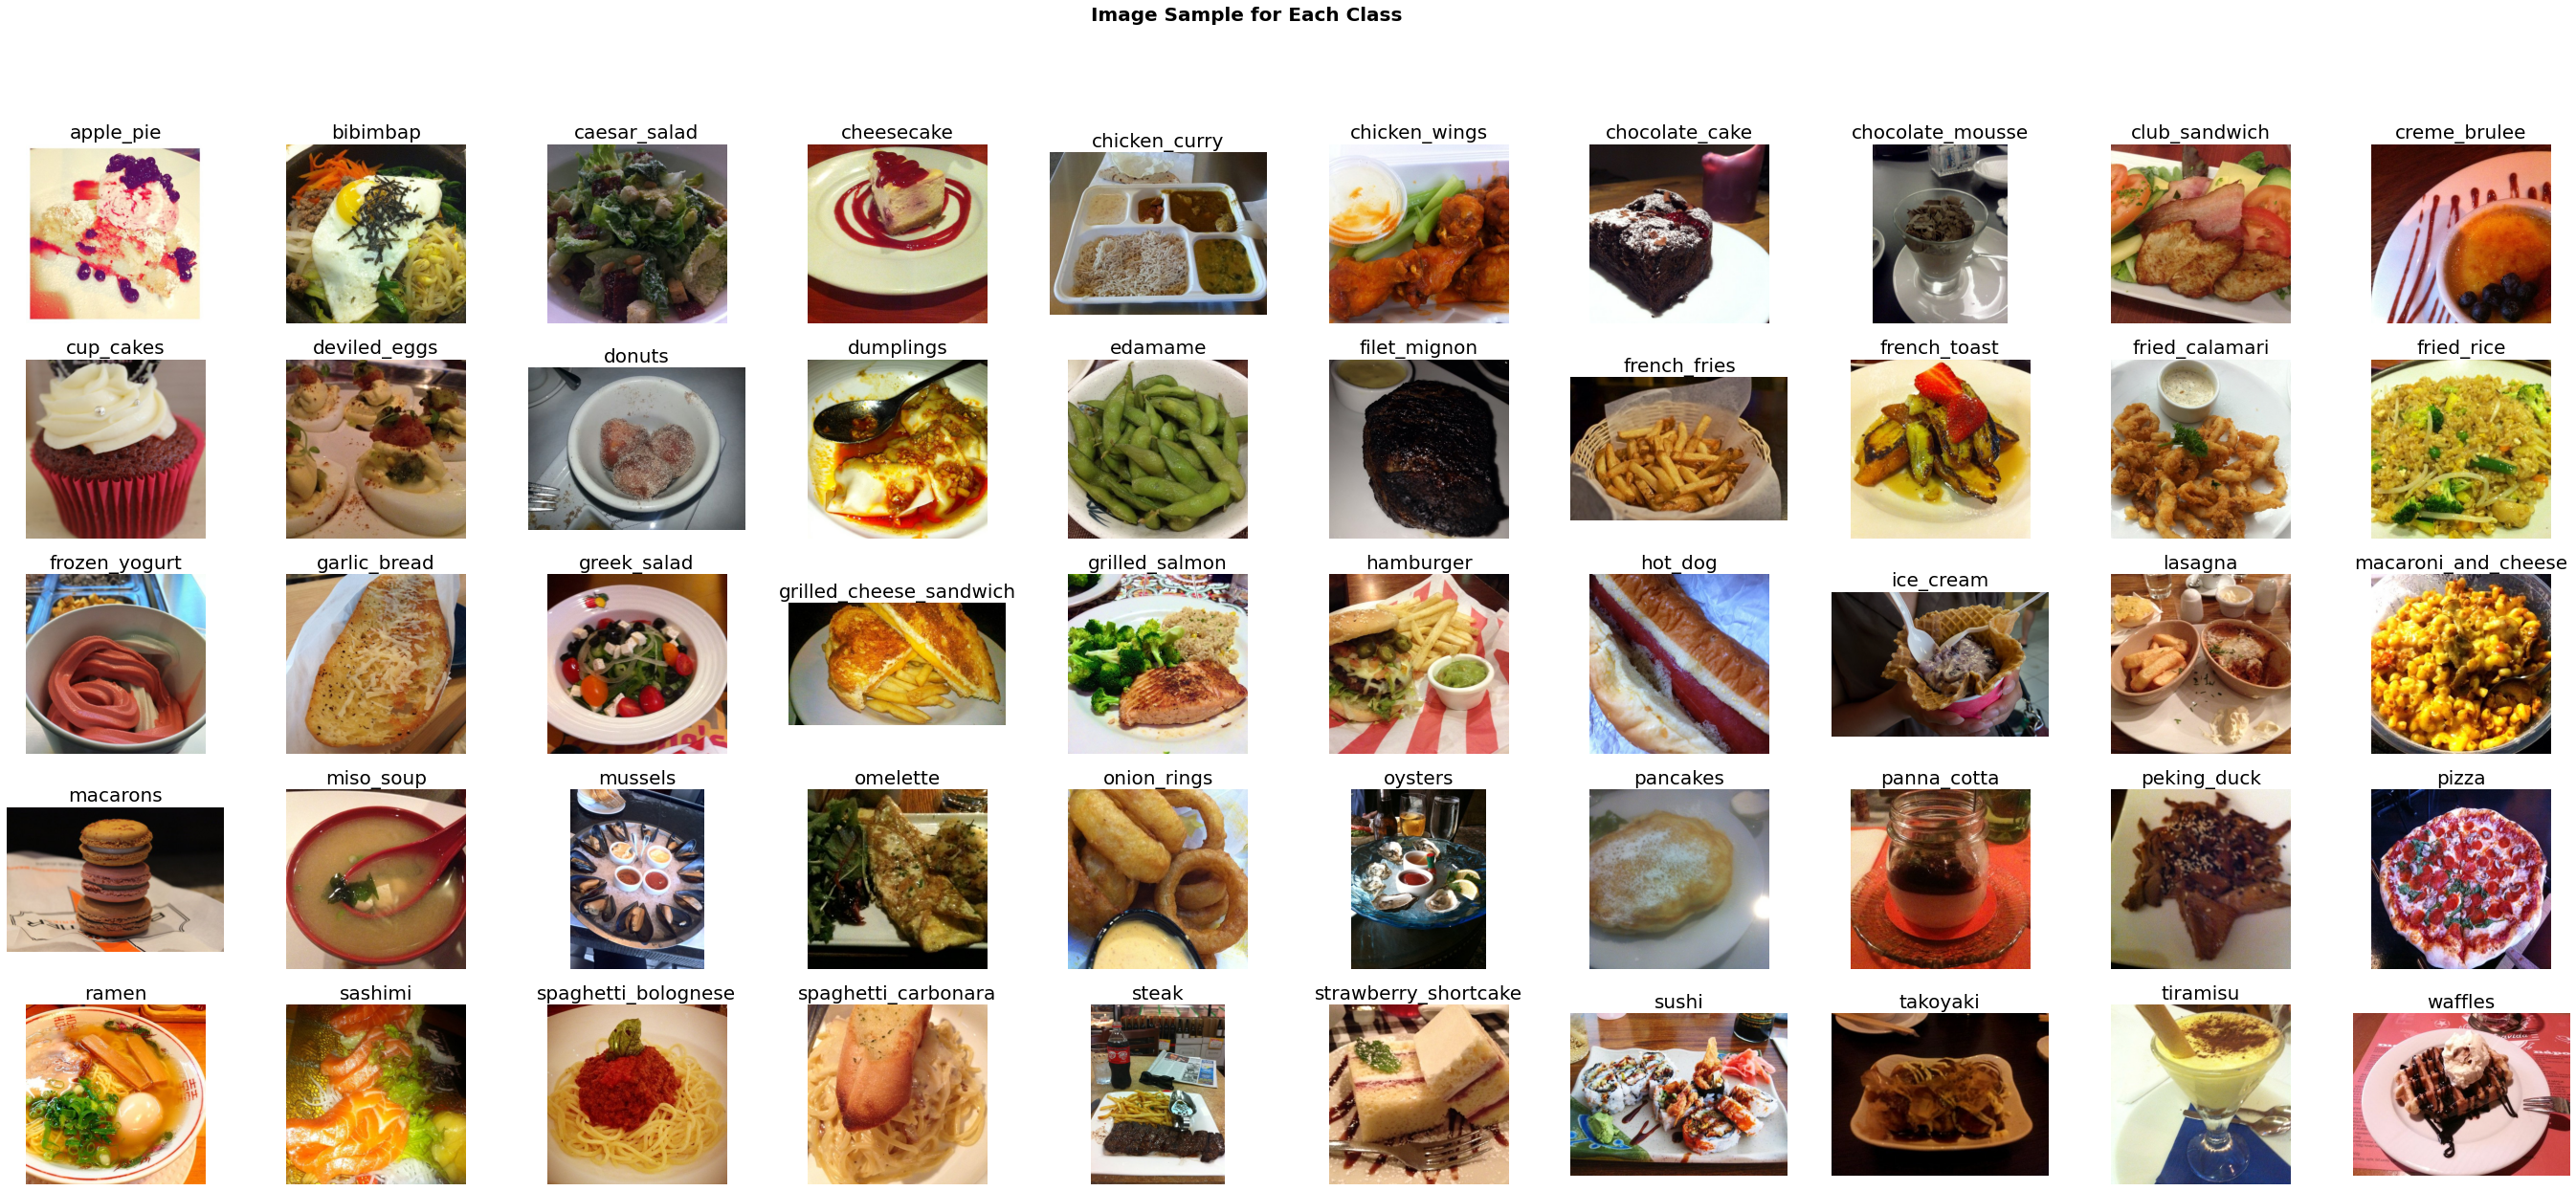

In [ ]:
# Image Visualization
fig, ax = plt.subplots(nrows= 5, ncols= 10, figsize=(48, 20))
plt.suptitle('Image Sample for Each Class', fontsize=20, weight='bold')

# Row 1
for i in range(10):
    ax[0, i].imshow(Image.open(df[df['class']==i].iloc[0]['filepath']))
    ax[0, i].set_title(df[df['class']==i].iloc[1]['class_name'], fontsize=20)
    ax[0, i].set_axis_off()

# Row 2
for i in range(10):
    ax[1, i].imshow(Image.open(df[df['class']==i+10].iloc[0]['filepath']))
    ax[1, i].set_title(df[df['class']==i+10].iloc[1]['class_name'], fontsize=20)
    ax[1, i].set_axis_off()

# Row 3
for i in range(10):
    ax[2, i].imshow(Image.open(df[df['class']==i+20].iloc[0]['filepath']))
    ax[2, i].set_title(df[df['class']==i+20].iloc[1]['class_name'], fontsize=20)
    ax[2, i].set_axis_off()

# Row 4
for i in range(10):
    ax[3, i].imshow(Image.open(df[df['class']==i+30].iloc[0]['filepath']))
    ax[3, i].set_title(df[df['class']==i+30].iloc[1]['class_name'], fontsize=20)
    ax[3, i].set_axis_off()

# Row 5
for i in range(10):
    ax[4, i].imshow(Image.open(df[df['class']==i+40].iloc[0]['filepath']))
    ax[4, i].set_title(df[df['class']==i+40].iloc[1]['class_name'], fontsize=20)
    ax[4, i].set_axis_off()

plt.show()

From image visualization above, We can see each image has different images shape and size. Those image also seems to be collected from individuals, This will be a good dataset for this project, because it  represents the food in the real world.

## IV. Data Preprocessing
In this part of process, I will prepare the data pipeline so that my model can be trained efficiently. Also I will split the dataset into training and validation dataset. 


In [ ]:
# Data pipeline

# Function for extracting image and its respective label
def load_image(filepath, label):
  img = tf.io.read_file(filepath) # Read image file
  img = tf.image.decode_image(img, channels=3, expand_animations=False) # Decode any input image to rgb channels
  img = tf.image.resize(img, (128, 128)) # resize input image to 128x128
  img = tf.cast(img, tf.uint8) # Convert input image to uint8 format to preserve space
  return img, label

# Creating the dataset
n_dataset = len(files)
dataset = tf.data.Dataset.from_tensor_slices((files, classes)).shuffle(n_dataset).map(load_image, num_parallel_calls=-1)

In [ ]:
# Split dataset into train and test

train_ds = dataset.take(int(0.8 * n_dataset)).shuffle(64, reshuffle_each_iteration=True).cache() # take 80% of dataset for training
val_ds = dataset.skip(int(0.8 * n_dataset)).cache() # Skip the first 80% of dataset and take the rest for validation, do nott shuffle the validation dataset

For faster training process, I will load the dataset into memory first.

In [ ]:
# Pre-load data into RAM (Hot-loading)

for _ in train_ds.batch(64):
  pass

for _ in val_ds.batch(64):
  pass

## V. Model Definition
In this part of process, I will define the model architecture for this project. I will utilize the pre-trained model available in https://www.tensorflow.org/api_docs/python/tf/keras/applications.\
After several trial and errors (which not shown in this notebook), I decided to use `DenseNet201` model, the main reason is because it has the best performance for this dataset among all other models.\
I will take the middle layer of the model and freeze the weights.

In [ ]:
# Load pre-trained model
pt_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', pooling=None)

# Freeze pre-trained model weight
pt_model.trainable = False

pt_model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                       

Below, I'll add following augmentation process in the input layers:
- Gaussian Noise
- Random Zoom
- Random Contrast

After that I'll put the image into pre trained model and then flatten it before put it into the fully connected layers. For fully connected layer, I'll use `1024` nodes with `Relu` activation function.\
For output layer, I'll use `Softmax` activation function because I will classify 50 classes. You can see the full architechture below.

In [ ]:
# Create sequential model
model= Sequential()

# Add augmentation
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.RandomZoom(0.2))
model.add(tf.keras.layers.RandomContrast(0.2))

# Add Pre-trained model
model.add(pt_model)

# Add Flatten Layer
model.add(Flatten())

# Add Fully Connected Layer.
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

# Add Output Layer
model.add(Dense(len(set(classes)), activation='softmax'))

# # Set learning Rate Scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=n_dataset//128, decay_rate=0.96)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 128, 128, 3)      0         
 se)                                                             
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 128, 128, 3)      0         
 rast)                                                           
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0

## VII Model Training

Now let's train the model

In [ ]:
# Set Callbacks
callbacks = [EarlyStopping(
                           monitor = 'val_loss',
                           mode = 'min',
                           patience = 10, 
                           restore_best_weights=True),
                           
            ModelCheckpoint('drive/MyDrive/Final_Project/Model_Checkpoint/DenseNet201.h5', 
                            monitor='val_loss', 
                            save_best_only=True)
            ]

In [ ]:
#fitting model
History = model.fit(train_ds.batch(256), validation_data= val_ds.batch(256), epochs=128, callbacks=callbacks)

# Save history as dataframe for evaluation purpose
metrics_df = pd.DataFrame(History.history)

Epoch 1/128
149/149 [==============================] - 112s 583ms/step - loss: 2.8257 - accuracy: 0.2851 - val_loss: 1.9174 - val_accuracy: 0.4833
Epoch 2/128
149/149 [==============================] - 75s 505ms/step - loss: 2.2359 - accuracy: 0.4052 - val_loss: 1.7333 - val_accuracy: 0.5264
Epoch 3/128
149/149 [==============================] - 75s 507ms/step - loss: 2.0397 - accuracy: 0.4480 - val_loss: 1.6513 - val_accuracy: 0.5458
Epoch 4/128
149/149 [==============================] - 75s 506ms/step - loss: 1.9224 - accuracy: 0.4763 - val_loss: 1.5939 - val_accuracy: 0.5624
Epoch 5/128
149/149 [==============================] - 76s 509ms/step - loss: 1.8238 - accuracy: 0.5003 - val_loss: 1.5876 - val_accuracy: 0.5600
Epoch 6/128
149/149 [==============================] - 76s 508ms/step - loss: 1.7451 - accuracy: 0.5169 - val_loss: 1.5100 - val_accuracy: 0.5822
Epoch 7/128
149/149 [==============================] - 71s 480ms/step - loss: 1.6676 - accuracy: 0.5384 - val_loss: 1.5133 

In [ ]:
# Save model
model.save('drive/MyDrive/Final_Project/Model_Checkpoint/DenseNet201.h5')

## VIII. Model Evaluation

Now let's see the performance of the model.

**Accuracy and Loss Curves**

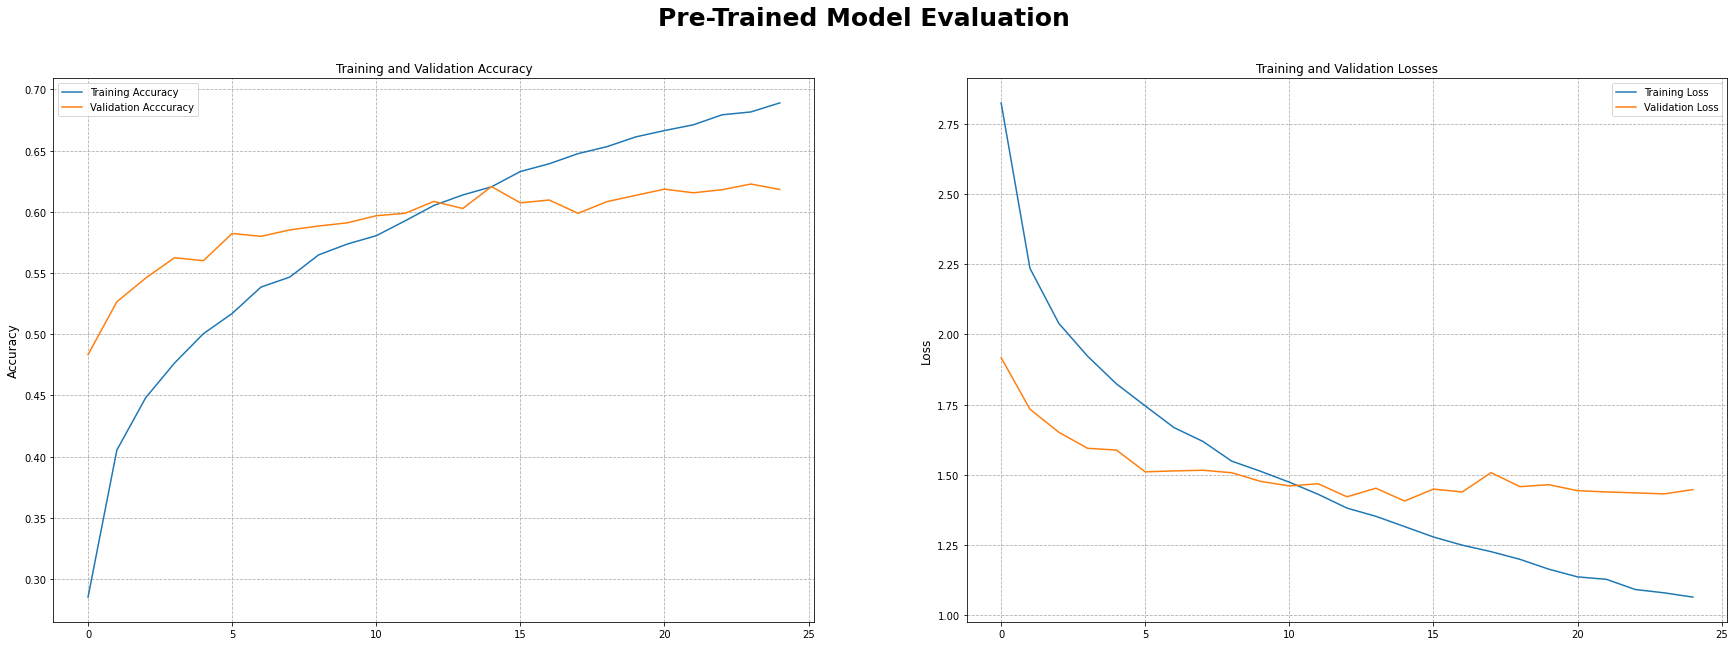

In [ ]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Pre-Trained Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(metrics_df.accuracy,label="Training Accuracy")
plt.plot(metrics_df.val_accuracy, label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(metrics_df.loss, label="Training Loss")
plt.plot(metrics_df.val_loss, label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

**Accuracy Evaluation**
- Both curves intersect at epochs below 10, though they separate again after that
- `Training curves` reach accuracy as high as 0.7 but `Validation curves` only reach as high as 0.8. This definitely shows that the model is `overfitting`
- Starting at epoch = 50, both curves shows stagnant result

**Loss Evaluation**
- Both curves intersect at epochs below 10, though they separate again after that
- `Training curves` reach loss as low as 0.7 but `Validation curves` only reach as low as 1.4 This also shows that the model is `overfitting`
- Starting at epoch = 50, both curves shows stagnant result

I already tried my best to figure out the best settings for my model. I already tried several other pre-trained model, tried different `neuron count, batch size, learning rate value, etc.` and this was the best performance that I could get. I needed more time to explore other possible option, but I decided to save the improvement for my next project. Hence I'll let my model for now to `overfit`.

**Classification Report**

In [ ]:
# Sampling
sample_x = []
sample_y = []

for x, y in val_ds.batch(64):
  sample_x.extend(x.numpy()) 
  sample_y.extend(y.numpy())

In [ ]:
# Convert to Array
sample_x = np.array(sample_x)
sample_y = np.array(sample_y)

In [ ]:
# Predict
output_y = model.predict(sample_x, batch_size=64)
output_y = np.argmax(output_y, axis=1)

In [ ]:
# Classification Report
target_names = classes_mapping.keys()
print(classification_report(sample_y, output_y, target_names=target_names))

                         precision    recall  f1-score   support

              apple_pie       0.54      0.43      0.48       192
               bibimbap       0.72      0.79      0.76       185
           caesar_salad       0.62      0.69      0.65       182
             cheesecake       0.40      0.53      0.46       191
          chicken_curry       0.54      0.58      0.56       179
          chicken_wings       0.57      0.80      0.67       185
         chocolate_cake       0.58      0.61      0.60       189
       chocolate_mousse       0.50      0.46      0.48       188
          club_sandwich       0.72      0.38      0.49       189
           creme_brulee       0.73      0.68      0.70       217
              cup_cakes       0.74      0.76      0.75       192
           deviled_eggs       0.87      0.53      0.66       182
                 donuts       0.71      0.71      0.71       194
              dumplings       0.82      0.79      0.80       202
                edamame 

**Classification Report Evaluation**
- Looking at the support for each class, I can say that my dataset is well balanced
- Looking at `accuracy, macro avg, weighted avg` score, I can say my model did quite well in classifying each class, though it can achieve a better result by tune the model once more
- Looking at `f1 Score`, my model could predict some class better than the others. My model good at predicting `XXXX` class but bad at predicting `XXX` class
- 

## IX. Model Inference

Now let's see how the model performed with inference image taken from outside of the dataset.

In [ ]:
# Load saved model
model = load_model('drive/MyDrive/Final_Project/Model_Checkpoint/DenseNet201.h5')

In [ ]:
# Define function to load images
def load_inf_image(filepath):
  # img = tf.io.read_file(filepath) # Read image file
  img = tf.io.decode_image(filepath, channels=3, expand_animations=False) # Decode any image to rgb channels
  img = tf.image.resize(img, (128, 128)) # resize image to 128x128
  img = tf.cast(img, tf.uint8) # Convert image to uint8
  return img

**From Downloaded Image**

In [ ]:
# Load Inference Images
inf1 = load_inf_image(tf.io.read_file('/content/dataset/Img_Class_Dataset/images/french_fries/100148.jpg'))
inf2 = load_inf_image(tf.io.read_file('/content/dataset/Img_Class_Dataset/images/club_sandwich/1050512.jpg'))
inf3 = load_inf_image(tf.io.read_file('/content/dataset/Img_Class_Dataset/images/lasagna/1028961.jpg'))
inf4 = load_inf_image(tf.io.read_file('/content/dataset/Img_Class_Dataset/images/donuts/104498.jpg'))
inf5 = load_inf_image(tf.io.read_file('/content/dataset/Img_Class_Dataset/images/fried_rice/1008935.jpg'))

inf_set = [inf1, inf2, inf3, inf4, inf5]

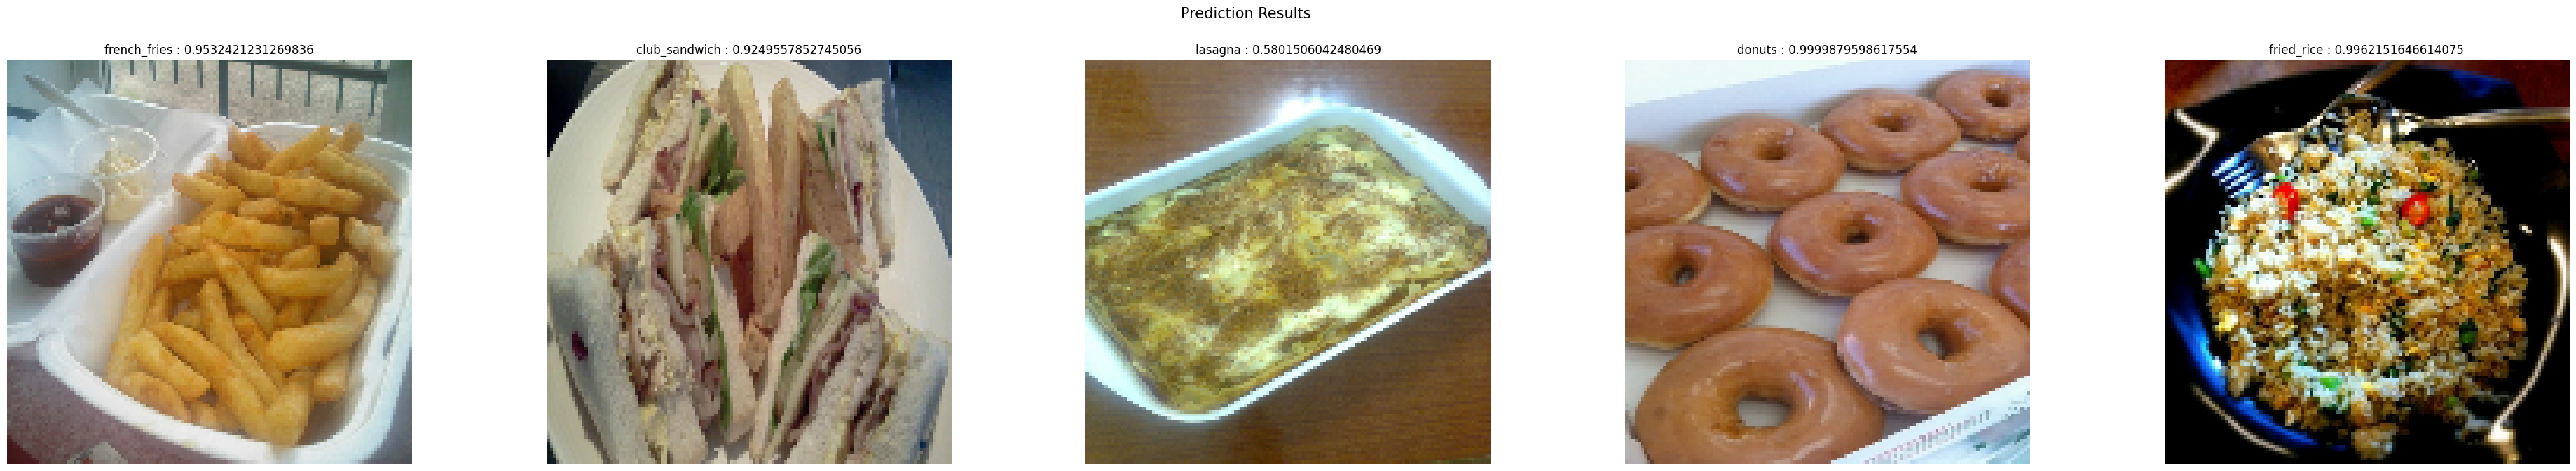

In [ ]:
# Predict and show result
plt.figure(figsize=(48, 7.5))
plt.suptitle('Prediction Results', fontsize=15)
counter = 1
for i in inf_set:
    plt.subplot(1, 5, counter)

    res = model.predict(x=expand_dims(i, axis=0))
    res_idx = np.argmax(res, axis=1)[0]

    plt.imshow(i)
    plt.title(f'{inv_classes_mapping[res_idx]} : {res[0, res_idx]}', fontsize=12)
    plt.axis('off')
    counter += 1
plt.show()

**From Internet URL**

In [ ]:
#  Save images URL from the net

url = [
       'https://media-cdn.tripadvisor.com/media/photo-s/1b/b5/0e/a5/pizza-hut-belfield.jpg',
       'https://asset.kompas.com/crops/4ioi2F8556ONp9yAhMIgqEHxpZo=/0x318:675x768/750x500/data/photo/2021/04/28/608907ecb7ddc.jpeg',
       'https://img.beritasatu.com/cache/beritasatu/620x350-2/1426126619.jpg',
       'https://image-cdn.medkomtek.com/A34FLYsn-zm5IYnWSjT-zlgzp9w=/640x480/smart/klikdokter-media-buckets/medias/2320889/original/057936200_1604487548-Manfaat-Kacang-Edamame-untuk-Kecantikan-shutterstock_718434649.jpg',
       'https://s3.theasianparent.com/tap-assets-prod/wp-content/uploads/sites/24/2021/12/kalori-hamburger-11-1.jpg',
       ]

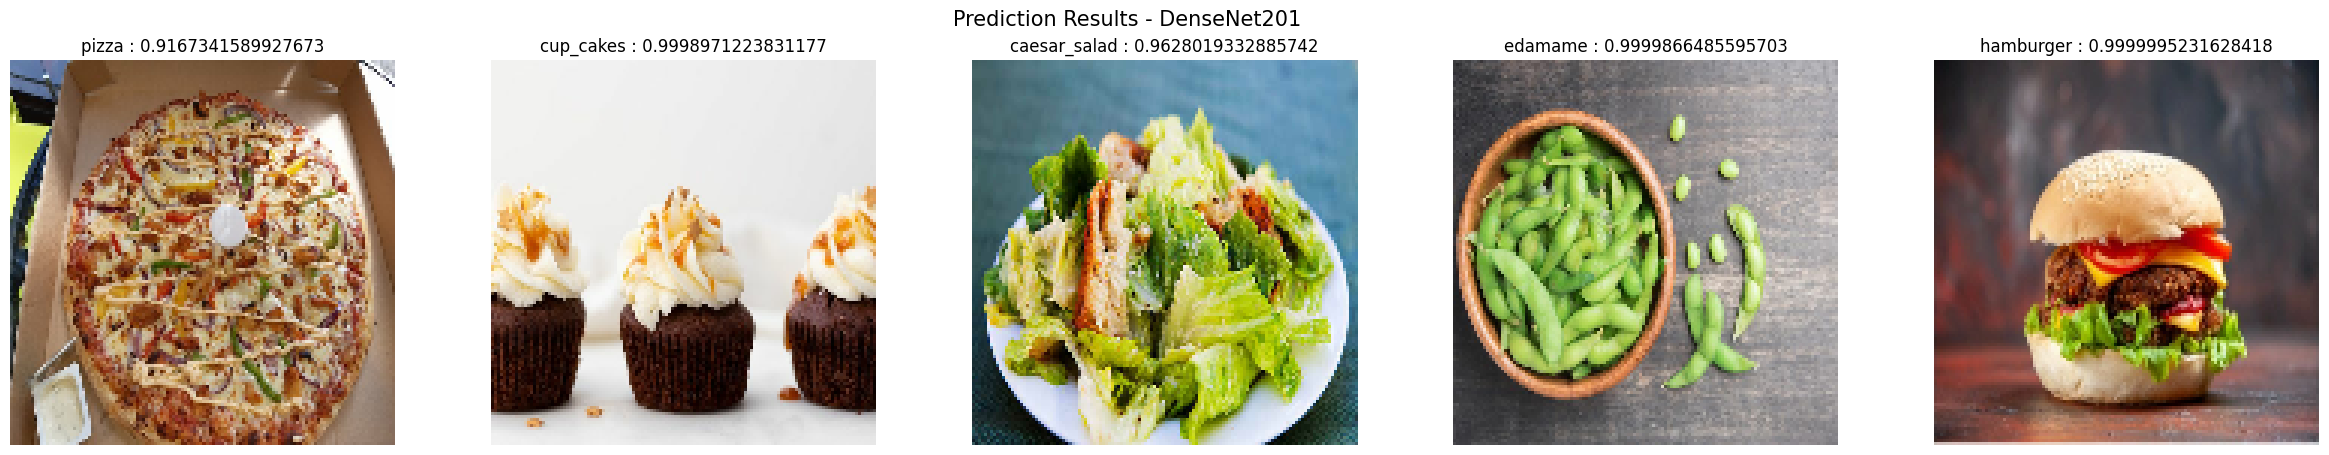

In [ ]:
# Predict and show result
plt.figure(figsize=(30, 5))
plt.suptitle('Prediction Results - DenseNet201', fontsize=15)

for i in range(len(url)):
    response = requests.get(url[i])
    img = load_inf_image(response.content) 

    plt.subplot(1, len(url), i+1)
    plt.imshow(img)

    res = model.predict(x=expand_dims(img, axis=0))
    res_idx = np.argmax(res, axis=1)[0]

    plt.title(f'{inv_classes_mapping[res_idx]} : {res[0, res_idx]}', fontsize=12)
    plt.axis('off')
plt.show()  

In [ ]:
#  Save images URL from the net

url = [
       'https://img-global.cpcdn.com/recipes/03ce988f1d9fcbb4/751x532cq70/takoyaki-praktis-ekonomis-foto-resep-utama.jpg',
       'https://akcdn.detik.net.id/api/wm/2021/11/14/fresh-oyster-mendadak-viral-ini-cara-tahu-cirinya-yang-masih-segarpexelcomlachlan-ross_169.jpeg',
      'https://d12man5gwydfvl.cloudfront.net/wp-content/uploads/2017/05/shutterstock_1688376010-1-940x700.jpg',
       'https://i.pinimg.com/736x/6f/2f/89/6f2f89131fd47feac3564e765e81869f--fries-classic.jpg',
       'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRI_Z9HqjC5YwyFYMYGl-WvxUqx1SeIo_51mA&usqp=CAU',
       ]

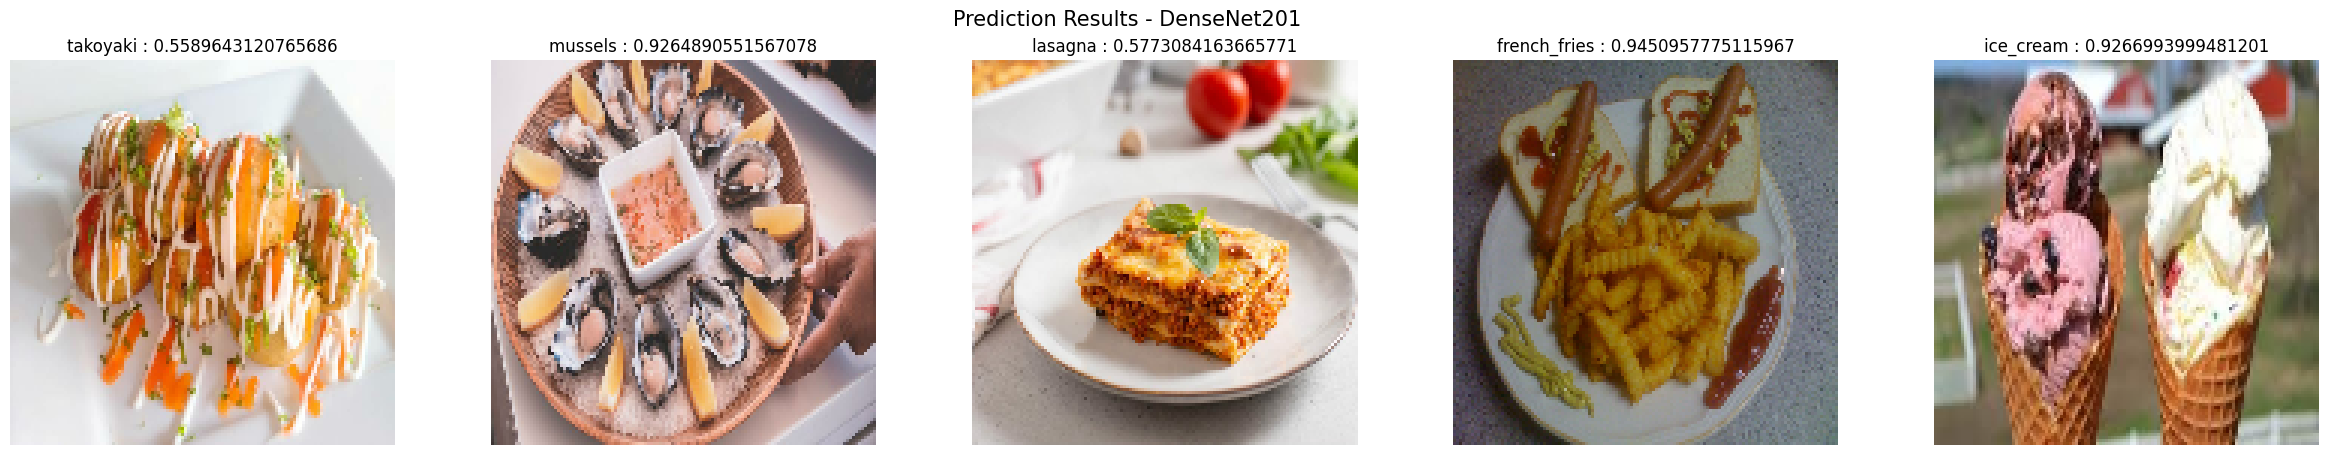

In [ ]:
# Predict and show result
plt.figure(figsize=(30, 5))
plt.suptitle('Prediction Results - DenseNet201', fontsize=15)

for i in range(len(url)):
    response = requests.get(url[i])
    img = load_inf_image(response.content) 

    plt.subplot(1, len(url), i+1)
    plt.imshow(img)

    res = model.predict(x=expand_dims(img, axis=0))
    res_idx = np.argmax(res, axis=1)[0]

    plt.title(f'{inv_classes_mapping[res_idx]} : {res[0, res_idx]}', fontsize=12)
    plt.axis('off')
plt.show()  

**Show Nutrional Facts for Predictedted Food**

In [ ]:
# Inference Image
inf6 = load_inf_image(tf.io.read_file("/content/dataset/Img_Class_Dataset/images/macarons/1005656.jpg"))


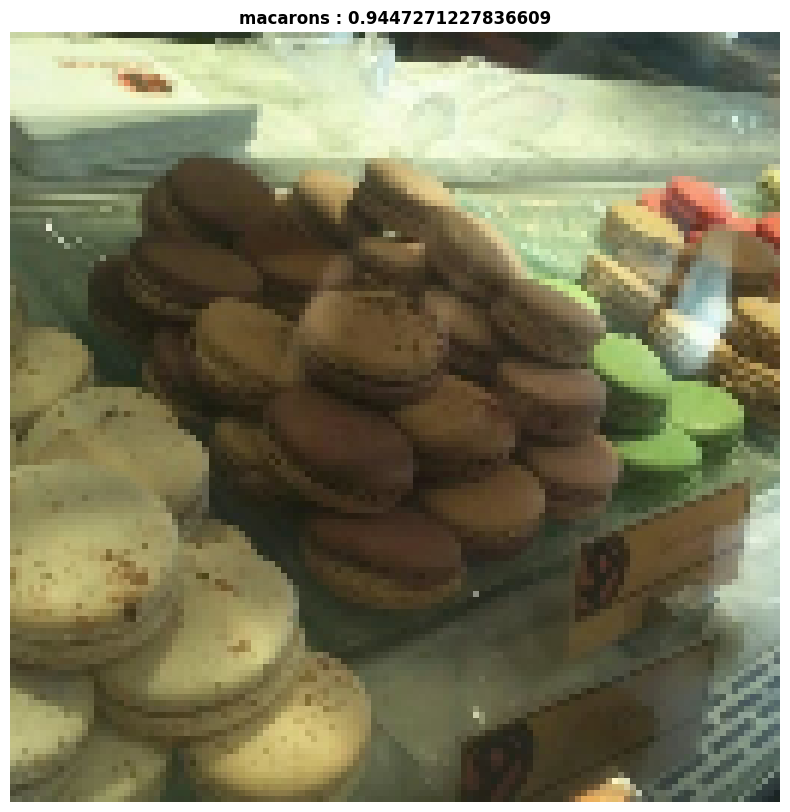

Nutritional Facts


No Nama_Makanan  Takaran_Saji (g)  Kalori  Total_Lemak (g)  \
30  31     macarons                11      43              1.9   

    Kolesterol (mg)  Sodium (mg)  Potassium (mg)  Total_Karbohidrat (g)  \
30              0.7         18.0              30                    6.0   

    Protein (g)  
30          0.8

In [ ]:
# Prediction
plt.figure(figsize=(10, 10))
res = model.predict(x=expand_dims(inf6, axis=0))
res_idx = np.argmax(res, axis=1)[0]

plt.imshow(inf6)
plt.title(f'{inv_classes_mapping[res_idx]} : {res[0, res_idx]}', fontsize=12, weight='bold')
plt.axis('off')

plt.show()

# Show Nutritional Facts
print('Nutritional Facts')
df_nutrition[df_nutrition['Nama_Makanan']==inv_classes_mapping[res_idx]]